In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os

## Raster plot generative model with a superposition of SMs
### Parameters

In [3]:
class world_params:
    N_pre = 20 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be a odd number for convolutions)
    N_kernels = 5 # number of SM used for RP generation
    
    p_input = .1 # probability of having spike for the input
    SM_ratio = 10 # coefficient that gives the SM/noise spike ratio
    N_timesteps =  2**10 # number of timesteps in the RP
    
    p_spontaneous = p_input/(1+SM_ratio) # probability of the spontaneous activity
    
    # TODO define all this better to work only with probability values
    avg_N_spikes = N_delays*N_pre*p_spontaneous # average number of spikes per SM
    std_N_spikes = 1 # variance for the number of spikes per SM
    
    #p_sm = p_input*SM_ratio/(1+SM_ratio)
    p_output = p_input*SM_ratio/((1+SM_ratio)*avg_N_spikes)
    
    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision
    
    seed = 4815162342 # seed

TODO: change something in the formula with SM_ratio

### Generative model

In [4]:
def gaussian_kernel(n_steps, mu, std):
    x = torch.arange(n_steps)
    return torch.exp(-(x-mu)**2/(2*std**2))/(std*torch.sqrt(torch.Tensor([2*torch.pi])))

class SM_World:
    def __init__(self, opt):
        # initialization of the parameters + drawing of the kernels
        self.opt: Params = opt
        self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
        for k in range(self.opt.N_kernels):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
                
    def draw_input(self, N_trials = 1, do_channels = False, sm_overlapping = True):
        
        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        
        if sm_overlapping:
            output_proba = torch.ones(N_trials, self.opt.N_kernels, self.opt.N_timesteps)*self.opt.p_output
            output_rp = torch.bernoulli(output_proba)
        else:
            N_output = int(self.opt.p_output*self.opt.N_kernels*self.opt.N_timesteps)
            output_rp = torch.zeros(N_trials, self.opt.N_kernels, self.opt.N_timesteps)
            for i in range(N_trials):
                address_output, time_output = torch.randint(self.opt.N_kernels, [N_output]), torch.randint(self.opt.N_delays, self.opt.N_timesteps, [N_output])
                sorted_ind = torch.argsort(time_output)
                time_output, address_output = time_output[sorted_ind], address_output[sorted_ind]
                ind = 0
                time_step = time_output[ind]
                while (time_step<self.opt.N_timesteps) & (ind<time_output.shape[0]):
                    time_step = time_output[ind]
                    non_overlapping_ind = np.where((time_output<=time_step) | (time_output>time_step+self.opt.N_delays))[0]
                    time_output, address_output = time_output[non_overlapping_ind], address_output[non_overlapping_ind]
                    ind += 1
                output_rp[i,address_output, time_output] = 1
        
        input_sm_proba = torch.conv_transpose1d(output_rp, self.kernels)
        input_sm_proba = torch.roll(input_sm_proba, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
        
        input_rp = torch.bernoulli(torch.minimum(input_sm_proba, torch.ones_like(input_sm_proba))) + spontaneous_activity
        
        if do_channels:
            input_rp_with_channels = torch.zeros(self.opt.N_kernels+1, N_trials, self.opt.N_pre, self.opt.N_timesteps)
            input_rp_with_channels[0,:,:,:] = spontaneous_activity
            for sm in range(self.opt.N_kernels):
                output_rp_with_channels = torch.zeros(N_trials, self.opt.N_kernels, self.opt.N_timesteps)
                output_rp_with_channels[:,sm,:] = output_rp[:,sm,:]
                input_sm_proba_with_channels = torch.conv_transpose1d(output_rp_with_channels, self.kernels)
                input_sm_proba_with_channels = torch.roll(input_sm_proba_with_channels, -self.kernels.shape[2], dims=2)[:,:,:-self.kernels.shape[2]+1]
                input_rp_with_channels[sm+1,:,:,:] = torch.bernoulli(torch.minimum(input_sm_proba_with_channels, torch.ones_like(input_sm_proba_with_channels)))
        
            return input_rp, output_rp, input_rp_with_channels
        else:
            return input_rp, output_rp

In [5]:
opt = world_params()
world = SM_World(opt)
input_rp, output_rp, input_rp_with_channels = world.draw_input(do_channels = True)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def plot_raster(raster, trial_nb = 0, colored=False, title = 'raster plot'):

    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    xticks, yticks = 6, 16 
    spikelength=.9
    colors = ['grey', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
    figsize = (12, 1.61803) 
    linewidths=1.0
    
    if colored: 
        N_kernels, N_trials, N_neurons, N_timesteps = raster.shape
    else: 
        N_trials, N_neurons, N_timesteps = raster.shape
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
    if colored:
        
        for i in range(0, N_neurons):
            for sm in range(N_kernels):
                ax.eventplot(np.where(raster[sm, trial_nb, i, :] > 0)[0], 
                    colors=colors[sm], lineoffsets=1.*i+spikelength/2,
                    linelengths=spikelength, linewidths=linewidths)
    else:
        for i in range(0, N_neurons):
            ax.eventplot(np.where(raster[trial_nb, i, :] > 0)[0], 
                colors=colors[0], lineoffsets=1.*i+spikelength/2,
                linelengths=spikelength, linewidths=linewidths)

    ax.set_ylabel('address')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, N_timesteps)
    ax.set_ylim(0, N_neurons)

    ax.set_yticks(np.arange(0, N_neurons, 1)+.5)
    ax.set_yticklabels('')#np.linspace(1, N_neurons, 9, endpoint=True).astype(int))
    for side in ['top', 'right']: ax.spines[side].set_visible(False)

    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(N_timesteps/4))
    ax.set_xticks(np.linspace(1, N_timesteps, xticks, endpoint=True))
    ax.set_xticklabels(np.linspace(1, N_timesteps, xticks, endpoint=True).astype(int))
    ax.set_title(title)
    
    ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
    #ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)
    return fig, ax

def plot_SM(SMs, N_show = 5, cmap='plasma', colors=None, aspect=None, figsize = (12, 1.61803)):
        
        subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

        N_SMs, N_pre, N_delays = SMs.shape
        
        fig, axs = plt.subplots(1, N_show, figsize=figsize, subplotpars=subplotpars)
        for i_SM in range(N_show):
            ax = axs[i_SM]
            ax.set_axisbelow(True)
            ax.pcolormesh(SMs[i_SM, :, :].flip(1), cmap=cmap, vmin=SMs.min(), vmax=SMs.max())
            #ax.imshow(self.SMs[:, i_SM, :], cmap=cmap, vmin=0, vmax=1, interpolation='none')
            ax.set_xlim(0, N_delays)
            ax.set_xlabel('Delay')
            t = ax.text(.805*N_delays, .95*N_pre, f'#{i_SM+1}', color='k' if colors is None else colors[i_SM])
            t.set_bbox(dict(facecolor='white', edgecolor='white'))
            if not aspect is None: ax.set_aspect(aspect)

            ax.set_ylim(0, N_pre)
            ax.set_yticks(np.arange(0, N_pre, 1)+.5)
            if i_SM>0: 
                ax.set_yticklabels([])
            else:
                ax.set_yticklabels(np.arange(0, N_pre, 1)+1)

            for side in ['top', 'right']: ax.spines[side].set_visible(False)
            ax.set_xticks([1, N_delays//3, (N_delays*2)//3])
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(N_delays//4))

        axs[0].set_ylabel('@ Neuron')
        return fig, axs

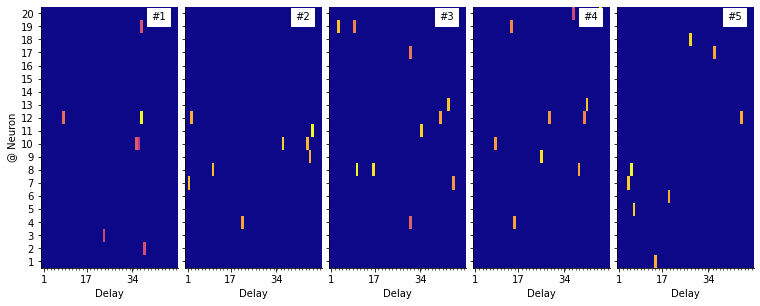

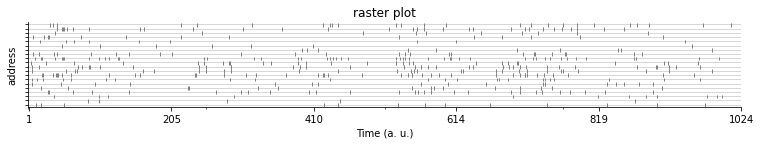

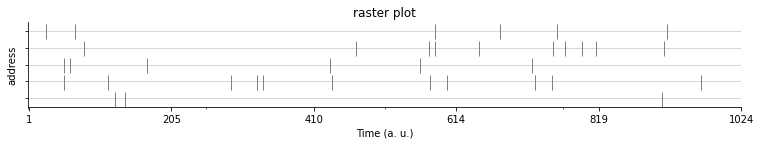

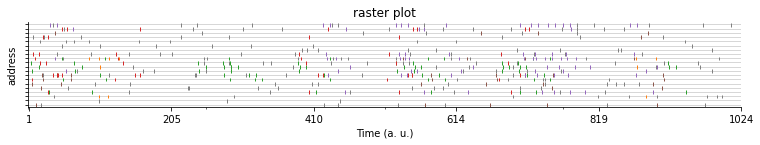

In [7]:
plot_SM(world.kernels, N_show = opt.N_kernels, figsize = (12, 5));
plot_raster(input_rp, colored=False);
plot_raster(output_rp, colored=False);
plot_raster(input_rp_with_channels, colored=True);

### Format the ouput for SpikeShip

In [8]:
def tensor2spikeship(rp_tensor):
    N_epochs, N_neurons, N_timesteps = rp_tensor.shape
    #epochs, neurons, times = np.where(rp_tensor>0)
    spike_times = np.array([])
    ii_spike_times = np.zeros([N_epochs, N_neurons, 2])
    for e in range(N_epochs):
        neurons, times = np.where(rp_tensor[e,:,:]>0)
        for n in np.unique(neurons):
            indices = np.where(neurons==n)[0]
            ii_spike_times[e,n,:] = [indices[0], indices[-1]]
            spike_times = np.hstack([spike_times,times[indices]]) if spike_times.shape[0]>0 else times[indices]
    return spike_times, ii_spike_times

In [9]:
input_rp, output_rp, input_rp_with_channels = world.draw_input(N_trials = 2, do_channels = True, sm_overlapping=False)

In [10]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)

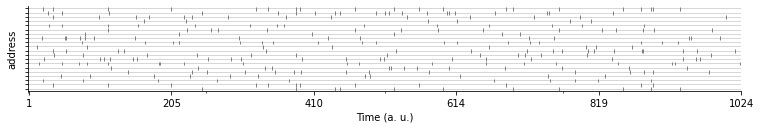

In [11]:
trial = 0
spikelength=.9
linewidths=1.0
xticks, yticks = 6, 16
N_timesteps = input_rp.shape[-1]
#raster = input_rp[trial,:,:]
N_neurons, _ = ii_spike_times[trial,:,:].shape
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)
fig, ax = plt.subplots(1, 1, figsize=(12, 1.61803), subplotpars=subplotpars)
for i in range(N_neurons):
    ax.eventplot(spike_times[np.arange(ii_spike_times[trial,i,0], ii_spike_times[trial,i,1]+1, dtype=np.uint8)], 
        colors='grey', lineoffsets=1.*i+spikelength/2,
        linelengths=spikelength, linewidths=linewidths)
ax.set_ylabel('address')
ax.set_xlabel('Time (a. u.)')
ax.set_xlim(0, N_timesteps)
ax.set_ylim(0, N_neurons)

ax.set_yticks(np.arange(0, N_neurons, 1)+.5)
ax.set_yticklabels('')#np.linspace(1, N_neurons, 9, endpoint=True).astype(int))
for side in ['top', 'right']: ax.spines[side].set_visible(False)

ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(N_timesteps/4))
ax.set_xticks(np.linspace(1, N_timesteps, xticks, endpoint=True))
ax.set_xticklabels(np.linspace(1, N_timesteps, xticks, endpoint=True).astype(int))
#ax.set_title(title)

ax.grid(visible=True, axis='y', linestyle='-', lw=.5)

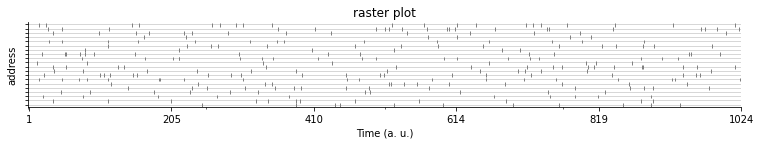

In [12]:
plot_raster(input_rp, colored=False);

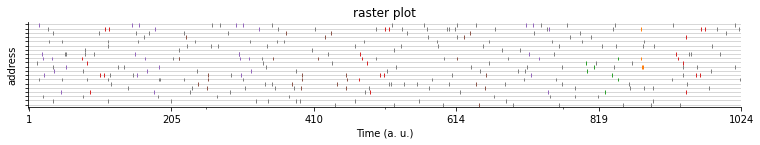

In [13]:
plot_raster(input_rp_with_channels, colored=True);